In [1]:
from sklearn.model_selection import train_test_split

from scripts.data_genertion.consts import *
from scripts.data_genertion.data_handling import populate_features, get_populate_fold
from scripts.features.feature_extraction import load_all_features

main_df = load_all_features()
main_df[SEQUENCE] = main_df[SEQUENCE].astype(str)

Loading features from: ['ASO_volume(nM).csv', 'Canonical Gene Name.csv', 'Cell line organism.csv', 'Cell_line.csv', 'Chemical_Pattern.csv', 'Density(cells_per_well).csv', 'ISIS.csv', 'Inhibition(%).csv', 'Linkage.csv', 'Linkage_Location.csv', 'Location.csv', 'Location_div_by_length.csv', 'Location_in_sequence.csv', 'Modification.csv', 'Primer_probe_set.csv', 'Sequence.csv', 'Target_gene.csv', 'Transcript.csv', 'Transfection.csv', 'Treatment_Period(hours).csv', 'at_rich_region_score.csv', 'at_skew.csv', 'cell_line_uniform.csv', 'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1382t37Trueon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1384t37Falseon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1384t37Trueon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1386t37Falseon_target_energy_max600.csv', 'dsm_su95_rev_wGU_pos1386t37Trueon_target_energy_max600.csv', 'dsm_su95_rev_woGU_pos1382t37Falseon_target_energy_max600.csv', 'dsm_su95_rev_woGU_pos1382t3

In [2]:
from scripts.data_genertion.consts import *

class Features:
    def __init__(self, features):
        self.__all_features = features
        self.__organize()

    def __organize(self):
        self.hybridization = []
        self.sequence = []
        self.fold = []
        self.one_hot = []
        for feature in self.__all_features:
            if "dsm" in feature:
                self.hybridization.append(feature)
            if feature in ['md_ps_hybr_norm', 'md_ps_hybr', 'exp_ps_hybr', 'exp_ps_hybr_norm', 'melting_temperature_1',
                           'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600'
                           ]:
                self.hybridization.append(feature)
            if CELL_LINE in feature:
                self.one_hot.append(feature)
            if feature in ['at_skew', 'gc_content', 'entropy', 'gc_skew',
                           'gc_content_3_prime_5', 'hairpin_score', 'homooligo_count', 'internal_fold',
                           'nucleotide_diversity', 'stop_codon_count', 'self_energy', 'at_rich_region_score', 'poly_pyrimidine_stretch']:
                self.sequence.append(feature)
            if 'on_target_fold' in feature or feature in ['mfe_edges_45', 'mfe_window_45']:
                self.fold.append(feature)

    def get_all(self):
        return self.hybridization + self.sequence + self.fold

main_df.columns

Index(['index', 'ASO_volume(nM)', 'Canonical Gene Name', 'Cell line organism',
       'Cell_line', 'Chemical_Pattern', 'Density(cells_per_well)', 'ISIS',
       'Inhibition(%)', 'Linkage', 'Linkage_Location', 'Location',
       'Location_div_by_length', 'Location_in_sequence', 'Modification',
       'Primer_probe_set', 'Sequence', 'Target_gene', 'Transcript',
       'Transfection', 'Treatment_Period(hours)', 'at_rich_region_score',
       'at_skew', 'cell_line_uniform',
       'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1382t37Trueon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1384t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1384t37Trueon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1386t37Falseon_target_energy_max600',
       'dsm_su95_rev_wGU_pos1386t37Trueon_target_energy_max600',
       'dsm_su95_rev_woGU_pos1382t37Falseon_target_energy_max600',
       'dsm_su95_rev_woGU_pos1382t37Trueon_target_energy_max600',

In [3]:
# populate_features(main_df, ['at_rich_region_score', 'poly_pyrimidine_stretch'])

In [4]:
# from scripts.features.feature_extraction import save_feature
#
# save_feature(main_df, 'at_rich_region_score')
# save_feature(main_df, 'poly_pyrimidine_stretch')

In [5]:
import numpy as np

filtered = main_df.copy()
filtered = filtered[filtered['Cell line organism'] == 'human']
filtered = filtered.dropna(subset=[INHIBITION]).copy()
# filtered = filtered.dropna(subset=[DENSITY_UPDATED]).copy()
filtered.loc[:, 'log_inhibition'] = -np.log(1.001 - filtered[INHIBITION] / 100)
filtered = filtered[~filtered[CELL_LINE].isin([
    'Hela', # scanning modifications
    'Human Neuronal Cell', # scanning modifications
    'CC-2580', # scanning modifications
    'SH-SY5Y' # non pure PS based
])]

In [6]:
# filtered = filtered[filtered['Linkage'] == 'phosphorothioate']
def log_inhibition_to_regular(log_inhibition):
    return 100 * (-np.exp(-log_inhibition) + 1.001)

mean_metric = 'log_inhibition'

filtered['mean_inhibition'] = filtered.groupby('ISIS')[mean_metric].transform('mean')
filtered = filtered.drop_duplicates(subset='ISIS').assign(**{mean_metric : filtered['mean_inhibition']}).drop(columns='mean_inhibition')

moe_pattern = 'MMMMMddddddddddMMMMM'
# filtered = filtered[filtered['Chemical_Pattern'] == moe_pattern].copy()
# filtered = filtered[filtered[VOLUME] == 2500].copy()

filtered['log_volume'] = np.log(filtered[VOLUME])
filtered['log_treatment'] = np.log(filtered[TREATMENT_PERIOD])
filtered['correct_log_inhibition'] = filtered['log_inhibition'] / (filtered['log_volume'])

features_obj = Features(filtered.columns)
features_obj.hybridization = ['exp_ps_hybr']
features_obj.fold = ['on_target_fold_openness_normalized40_15']
# features_obj.fold = []
features = features_obj.get_all()
# features = features_obj.hybridization + features_obj.fold
epi_features = [
                TREATMENT_PERIOD,
                # 'log_volume',
                # DENSITY_UPDATED
]

# features = epi_features
features = epi_features + features

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRanker

train, test = train_test_split(filtered, test_size=0.2)
train = train.sort_values(CELL_LINE)
group_train = train.groupby(CELL_LINE).size().tolist()
metric = 'correct_log_inhibition'

print("Test: ", len(test))
print("Train: ", len(train))
X = train[features]
# y = train.groupby(CELL_LINE)[metric].rank(method='dense', ascending=True).astype(int)
y = train[metric]


model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk")
# model = XGBRanker(objective='rank:pairwise')
model.fit(X.to_numpy(), y.to_numpy(), group=group_train)


Test:  3387
Train:  13544


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, feature_weights=None,
          gamma=None, grow_policy=None, importance_type=None,
          interaction_constraints=None, lambdarank_pair_method='topk',
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, ...)

log_inhibition
Cell line:  A431
P:  0.1444031820792856
S:  0.1582315475629254
log_inhibition
Cell line:  Human IPS
P:  0.7844080465746457
S:  0.7540311361529615
log_inhibition
Cell line:  KARPAS-229
P:  0.5805609075995761
S:  0.5819669285843765
log_inhibition
Cell line:  A-431
P:  0.9153824389601987
S:  0.7206268740527327
log_inhibition
Cell line:  MM.1R
P:  0.5610626358362146
S:  0.5351220286371033
log_inhibition
Cell line:  SK-MEL-28
P:  0.34385781504799007
S:  0.30171452201334353
log_inhibition
Cell line:  SNU-449
P:  0.5347292950007854
S:  0.42752997795354564
log_inhibition
Cell line:  HepaRG
P:  0.43553778949509814
S:  0.3345285687058357
log_inhibition
Cell line:  U251
P:  0.7388323876846258
S:  0.6457619301454054
log_inhibition
Cell line:  HepG2
P:  0.4147929668501334
S:  0.403551389793166
PTRAIN:  0.38872080498392253
PTEST:  0.3717622142640201
STRAIN:  0.3246264898764937
STEST:  0.33351490807734707


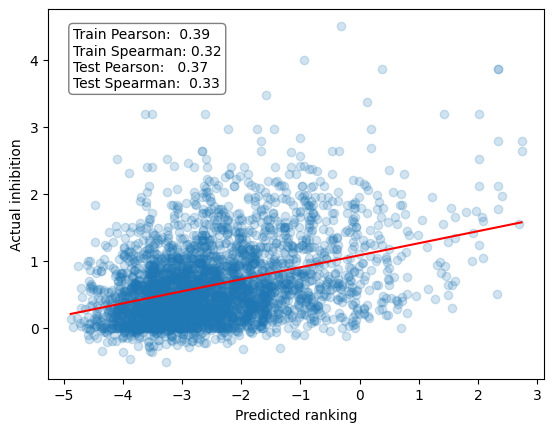

In [29]:
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr

train_filtered = train.copy()
test_filtered = test.copy()

# train_filtered = train.nlargest(200, metric)
# test_filtered = test.nlargest(200, metric)

train_pred = model.predict(train_filtered[features].to_numpy())
test_pred = model.predict(test_filtered[features].to_numpy())

y_test = test_filtered[metric].to_numpy()
y_train = train_filtered[metric].to_numpy()

cell_lines = filtered[CELL_LINE].unique()
for cell_line in cell_lines:
    hepa_mask = filtered[CELL_LINE] == cell_line
    hep_pred = model.predict(filtered[hepa_mask][features].to_numpy())
    print(metric)
    hepa_truth = filtered[hepa_mask][metric]
    p_hepa, _ = pearsonr(hepa_truth, hep_pred)
    s_hepa, _ = spearmanr(hepa_truth, hep_pred)
    print("Cell line: ", cell_line)
    print("P: ", p_hepa)
    print("S: ", s_hepa)

p_train, _ = pearsonr(y_train, train_pred)
s_train, _ = spearmanr(y_train, train_pred)
p_test, _ = pearsonr(y_test, test_pred)
s_test, _ = spearmanr(y_test, test_pred)

print("PTRAIN: ", p_train)
print("PTEST: ", p_test)
print("STRAIN: ", s_train)
print("STEST: ", s_test)

# scatter plot
plt.scatter(test_pred, y_test, alpha=0.2)

# least‑squares regression line
slope, intercept = np.polyfit(test_pred, y_test, 1)
x = np.linspace(test_pred.min(), test_pred.max(), 100)
plt.plot(x, slope * x + intercept, color='red')

# labels and stats
plt.xlabel('Predicted ranking')
plt.ylabel('Actual inhibition')
txt = (
    f"Train Pearson:  {p_train:.2f}\n"
    f"Train Spearman: {s_train:.2f}\n"
    f"Test Pearson:   {p_test:.2f}\n"
    f"Test Spearman:  {s_test:.2f}"
)
plt.text(
    0.05, 0.95, txt,
    transform=plt.gca().transAxes,
    va='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

plt.show()


In [30]:
def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean())

In [31]:
def get_threshold_for_percentile(percentile, df):
    k = max(1, int(np.ceil((percentile/ 100) * len(df))))      # desired count
    threshold = np.partition(df, -k)[-k]          # value at 99th percentile
    return threshold


def correction(df):
    return (df['log_volume'])

for percentile in [1, 5, 10, 50]:
    threshold = get_threshold_for_percentile(percentile, log_inhibition_to_regular(filtered['log_inhibition']) )
    # print(correction(filtered))
    # print(log_inhibition_to_regular(filtered['log_inhibition']))
    print(f"Threshold for top_{percentile}: {threshold}")

Threshold for top_1: 92.0
Threshold for top_5: 83.1687900148509
Threshold for top_10: 76.0
Threshold for top_50: 39.0


Mean model:  82.96838526327376
Mean best:  96.91896956627058
Mean random:  39.08418470588025
Mean model:  81.09255940384304
Mean best:  96.91198875691964


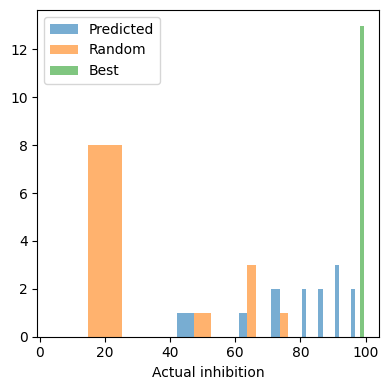

In [11]:
percentile = 0.5

train_threshold = get_threshold_for_percentile(percentile, train_pred)
test_threshold = get_threshold_for_percentile(percentile, test_pred)


test_mask = test_pred > test_threshold

top_k = test_mask.sum()

train_mask = train_pred > train_threshold

top_predicted_train = train_pred[train_mask]


top_train = log_inhibition_to_regular(y_train[train_mask] * correction(train_filtered[train_mask]))

top_predicted_test = test_pred[test_mask]
top_test = log_inhibition_to_regular(y_test[test_mask] * correction(test_filtered[test_mask]))

# k already computed as the desired sample size
rand_mask = np.zeros(len(y_test), dtype=bool)
rand_mask[np.random.choice(len(y_test), top_k, replace=False)] = True

# ---------- best possible ----------
all_inhib   = log_inhibition_to_regular(y_test * correction(test_filtered))
top_best = all_inhib.nlargest(top_k).to_numpy()      # no index confusion

# random sample via mask
rand_perm = y_test[rand_mask]
top_rand_test = log_inhibition_to_regular(y_test[rand_mask] * correction(test_filtered[rand_mask]))

fig, ax = plt.subplots(figsize=(4,4))
# ax.boxplot([top_test, top_rand_test],
#            tick_labels=['Top‑predicted', 'Random baseline']
#            )
print("Mean model: ", np.mean(top_test))
print("Mean best: ", np.mean(top_best))
print("Mean random: ", np.mean(top_rand_test))

print("Mean model: ", geo_mean_overflow(top_test))
print("Mean best: ", geo_mean_overflow(top_best))
# print("Mean random: ", geo_mean_overflow(top_rand_test))
plt.hist([top_test, top_rand_test, top_best],
         bins=[0, 40, 60, 70, 80, 85, 90, 95, 100], alpha=0.6, label=['Predicted', 'Random', 'Best'])                 # ‑‑ y‑axis on log scale
plt.xlabel('Actual inhibition')
plt.legend()
plt.tight_layout()
plt.show()


In [42]:
MALAT_scores = model.predict(filtered[filtered[CANONICAL_GENE] == 'MALAT1'][features])
MALAT_scores.sort()
print(MALAT_scores)
get_threshold_for_percentile(1, MALAT_scores)

[-4.4362435 -4.3665233 -4.351904  ...  2.882956   3.9074833  4.493784 ]


np.float32(0.6800661)

In [12]:
# ---------------------------------------------------------------------------
# 5-fold “stable” permutation-importance for an XGBRanker (rank:pairwise)
# – one query = all rows that share the same CELL_LINE ----------------------
# ---------------------------------------------------------------------------

from xgboost import XGBRanker
from sklearn.model_selection import GroupKFold
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from scipy import stats
import numpy as np
import pandas as pd

metric   = "log_inhibition"          # target column
groups   = filtered[CELL_LINE]       # one “qid” per row
gkf      = GroupKFold(n_splits=6)

def spearman_scorer(est, X, y):      # (estimator, X, y) signature
    return stats.spearmanr(y, est.predict(X)).correlation ** 2

all_imps = []

for tr_idx, te_idx in gkf.split(filtered, filtered[metric], groups):
    # ---- build train / test sets -----------------------------------------
    train_df = filtered.iloc[tr_idx].sort_values(CELL_LINE)   # keep queries contiguous
    test_df  = filtered.iloc[te_idx]

    X_tr, y_tr = train_df[features], train_df[metric]
    X_te, y_te = test_df[features],  test_df[metric]

    group_train = train_df.groupby(CELL_LINE).size().tolist() # sizes per query

    # ---- fit a fresh ranker on this fold ---------------------------------
    ranker = XGBRanker(objective="rank:pairwise", random_state=42)
    ranker.fit(X_tr.to_numpy(), y_tr.to_numpy(), group=group_train)

    # ---- permutation importance on the hold-out --------------------------
    r = permutation_importance(
            ranker, X_te.to_numpy(), y_te.to_numpy(),
            n_repeats=30, scoring=spearman_scorer,
            random_state=42, n_jobs=-1
        )
    all_imps.append(r.importances_mean)

# --------------------------------------------------------------------------
# aggregate across folds
imp_mat = np.vstack(all_imps)                               # (folds × features)
imp_df  = pd.DataFrame(
            imp_mat.T,
            index   = features,
            columns = [f"fold_{i+1}" for i in range(imp_mat.shape[0])]
         )

summary = (imp_df
           .agg(["mean", "std"], axis=1)
           .rename(columns={"mean": "mean_imp", "std": "std_imp"})
           .sort_values("mean_imp", ascending=False))

print(summary.head(10))

                                         mean_imp   std_imp
on_target_fold_openness_normalized40_15  0.073956  0.064402
at_skew                                  0.034412  0.031111
gc_content                               0.032384  0.026021
gc_skew                                  0.018782  0.022133
self_energy                              0.012909  0.013359
entropy                                  0.011494  0.011576
hairpin_score                            0.009282  0.015501
exp_ps_hybr                              0.007331  0.029501
homooligo_count                          0.006199  0.007855
stop_codon_count                         0.003036  0.001237


In [43]:
GFP_IN_YEAST = ('ATGGTtAGtAAaGGaGAaGAGTTgTTCACaGGaGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGGGTGCTGGGGCAggtacCCCTAAAGATCCAGCCAAACCTCCGGCCAcGGCACAAGTTGTGGGATGGCCACCGGTGAGATCATACCGGAAGAACGTGATGGTTTCCTGCCAAAAATCAAGCGGTGGCCCGGAGGCGGCGGCGTTCGTGAAGTAA'
                .upper())
GFP_IN_HUMAN =("atggtgagcaagggcgaggagctgttcaccggggtggtgcccatcctggtcgagctggacggcgacgtaaacggccacaagttcagcgtgtccggcgagggcgagggcgatgccacctacggcaagctgaccctgaagttcatctgcaccaccggcaagctgcccgtgccctggcccaccctcgtgaccaccctgacctacggcgtgcagtgcttcagccgctaccccgaccacatgaagcagcacgacttcttcaagtccgccatgcccgaaggctacgtccaggagcgcaccatcttcttcaaggacgacggcaactacaagacccgcgccgaggtgaagttcgagggcgacaccctggtgaaccgcatcgagctgaagggcatcgacttcaaggaggacggcaacatcctggggcacaagctggagtacaactacaacagccacaacgtctatatcatggccgacaagcagaagaacggcatcaaggtgaacttcaagatccgccacaacatcgaggacggcagcgtgcagctcgccgaccactaccagcagaacacccccatcggcgacggccccgtgctgctgcccgacaaccactacctgagcacccagtccgccctgagcaaagaccccaacgagaagcgcgatcacatggtcctgctggagttcgtgaccgccgccgggatcactctcggcatggacgagctgtacaagaagcttagccatggcttcccgccggaggtggaggagcaggatgatggcacgctgcccatgtcttgtgcccaggagagcgggatggaccgtcaccctgcagcctgtgcttctgctaggatcaatgtgaagcgacctgccgccacaaagaaggctggacaggctaagaagaagaaatgaggatcccgcgcgcgcatatgttaattaaccaactgcatggggatccacgcgttaagtcgacaatcaacctctggattacaaaatttgtgaaagattgactggtattcttaactatgttgctccttttacgctatgtggatacgctgctttaatgcctttgtatcatgctattgcttcccgtatggctttcattttctcctccttgtataaatcctggttgctgtctctttatgaggagttgtggcccgttgtcaggcaacgtggcgtggtgtgcactgtgtttgctgacgcaacccccactggttggggcattgccaccacctgtcagctcctttccgggactttcgctttccccctccctattgccacggcggaactcatcgccgcctgccttgcccgctgctggacaggggctcggctgttgggcactgacaattccgtggtgttgtcggggaaatcatcgtcctttccttggctgctcgcctgtgttgccacctggattctgcgcgggacgtccttctgctacgtcccttcggccctcaatccagcggaccttccttcccgcggcctgctgccggctctgcggcctcttccgcgtcttcgccttcgccctcagacgagtcggatctccctttgggccgcctccccgcgtcgactttaagaccaatgacttacaaggcagctgtagatcttagccactttttaaaagaaaaggggggactggaagggctaattcactcccaacgaagacaagatctgctttttgcttgtactgggtctctctggttagaccagatctgagcctgggagctctctggctaactagggaacccactgcttaagcctcaataaagcttgccttgagtgcttcaagtagtgtgtgcccgtctgttgtgtgactctggtaactagagatccctcagacccttttagtcagtgtggaaaatctctagcagtacgtatagtagttcatgtcatcttattattcagtatttataacttgcaaagaaatgaatatcagagagtgagagg".upper()
)
# GFP + Degron x <= 842
# NLS 843 <= x<= 893
# 3UTR 1615 <= x <= 1848


In [44]:
from scripts.data_genertion.data_handling import get_unique_human_genes

from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR

cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=['MALAT1'])
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

MALAT = gene_to_data['MALAT1'].full_mrna

In [45]:
from asodesigner.util import get_antisense

def get_init_df(target_mrna):
    candidates = []
    sense_starts = []
    sense_lengths = []


    for i in range(0, len(target_mrna) - 19):
        target = target_mrna[i: i + 20]
        candidates.append(get_antisense(str(target)))
        sense_starts.append(i)
        sense_lengths.append(20)
    df = pd.DataFrame({SEQUENCE : candidates, SENSE_START : sense_starts, SENSE_LENGTH : sense_lengths})
    return df
df_yeast = get_init_df(GFP_IN_YEAST)
df_human = get_init_df(GFP_IN_HUMAN)
df_malat = get_init_df(MALAT)

In [ ]:
features

In [46]:
from scripts.data_genertion.data_handling import populate_features

df_yeast[CANONICAL_GENE] = 'YEAST_GFP'
df_human[CANONICAL_GENE] = 'HUMAN_GFP'
df_malat[CANONICAL_GENE] = 'MALAT'

dataframes = [df_yeast, df_human, df_malat]

for df in dataframes:
    df[TREATMENT_PERIOD] = 24 # keep constant for all
    df[VOLUME] = 1000 # keep constant for all
    easy_to_populate = ['at_skew', 'entropy', 'gc_content', 'gc_content_3_prime_5', 'gc_skew', 'hairpin_score', 'homooligo_count', 'internal_fold', 'nucleotide_diversity', 'self_energy','stop_codon_count', 'at_rich_region_score', 'poly_pyrimidine_stretch']
    populate_features(df, easy_to_populate)

In [47]:
%reload_ext autoreload
%autoreload 2

from asodesigner.process_utils import LocusInfo
from scripts.data_genertion.data_handling import get_populate_fold

genes_u = ['YEAST_GFP', 'HUMAN_GFP', 'MALAT']
gene_to_data = {'YEAST_GFP' : LocusInfo(), 'HUMAN_GFP' : LocusInfo(), 'MALAT' : LocusInfo()}
gene_to_data['YEAST_GFP'].full_mrna = GFP_IN_YEAST
gene_to_data['HUMAN_GFP'].full_mrna = GFP_IN_HUMAN
gene_to_data['MALAT'].full_mrna = MALAT


In [49]:
for i in range(len(dataframes)):
    fold_variants = [(40,15)]
    dataframes[i] = get_populate_fold(dataframes[i], genes_u, gene_to_data, fold_variants=fold_variants)


[-1.10000000e+001 -3.50000000e+000 -3.79999995e+000 -6.30000019e+000
 -1.20000000e+001 -1.40000000e+001 -8.50000000e+000 -5.50000000e+000
 -8.30000019e+000 -8.10000038e+000 -1.36999998e+001 -1.28999996e+001
 -8.50000000e+000 -1.11999998e+001 -1.35000000e+001 -1.06000004e+001
 -4.80000019e+000 -8.60000038e+000 -1.03000002e+001 -7.19999981e+000
 -8.80000019e+000 -4.09999990e+000 -1.61000004e+001 -3.00000000e+000
 -6.80000019e+000 -4.80000019e+000 -1.20000005e+000 -1.89999998e+000
  0.00000000e+000 -1.41999998e+001 -8.50000000e+000 -8.50000000e+000
 -1.11999998e+001 -1.25000000e+001 -5.00000000e+000 -8.19999981e+000
 -6.59999990e+000 -9.89999962e+000 -1.01999998e+001 -1.08000002e+001
 -7.30000019e+000 -9.80000019e+000 -1.58999996e+001 -1.06999998e+001
 -1.33000002e+001 -1.38999996e+001 -1.28999996e+001 -1.56000004e+001
 -1.25000000e+001 -5.30000019e+000 -4.19999981e+000 -2.79999995e+000
 -9.60000038e+000 -5.40000010e+000 -2.00000000e+000 -7.00000000e+000
 -1.46999998e+001 -9.60000038e+000

In [50]:
from hybridization.hybridization_features import get_exp_psrna_hybridization

for df in dataframes:
    df.loc[:, 'exp_ps_hybr'] = [
        get_exp_psrna_hybridization(antisense.replace('T', 'U'), temp=37) for
        antisense in df[SEQUENCE]]

In [51]:
scores_per_gfp = []
for df in dataframes:
    scores_per_gfp.append(model.predict(df[features]))

In [ ]:
index = 0
scores = scores_per_gfp[index]
k = 20  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
# df_with_scores.iloc[idx].to_csv('yeast_gfp_asos.csv', index=False)

In [ ]:
index = 1
scores = scores_per_gfp[index]
k = 20  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
# df_with_scores.iloc[idx].to_csv('human_gfp_asos.csv', index=False)


In [52]:
index = 2
scores = scores_per_gfp[index]
k = 20  # how many top rows
idx = np.argsort(-scores)[:k]
# print(df.iloc[idx])
# (optional) with scores:
df_with_scores = dataframes[index].assign(score=scores)
print(df_with_scores.iloc[idx])
df_with_scores.iloc[idx].to_csv('malat_asos.csv', index=False)

                  Sequence  sense_start  sense_length Canonical Gene Name  \
8263  CCAAGTCTGTTATGTTCACC         8263            20               MALAT   
4639  AAGCCACTTCCTTTGCTCTG         4639            20               MALAT   
7586  GACACTTCTCTTGACCTTAG         7586            20               MALAT   
1668  GCTCTGTAGTCCTTTCTCTC         1668            20               MALAT   
5804  TCCTTTCATAGAGCCTTCAG         5804            20               MALAT   
6077  GTTCTTCCGCTCAAATCCTG         6077            20               MALAT   
1606  ATCTCAACCTCCGTCATGTT         1606            20               MALAT   
8182  TGCCTATCTTCTCCAGTCTA         8182            20               MALAT   
1565  CTTCCTCATGCTACTCTTCT         1565            20               MALAT   
7589  GCTGACACTTCTCTTGACCT         7589            20               MALAT   
3289  CCATCTACTATTTCTCCAGG         3289            20               MALAT   
3609  TACACCTTGAGTCATTTGCC         3609            20               MALAT   

In [ ]:
index = 0
df_with_scores = dataframes[index].assign(score=scores_per_gfp[index])

previous_experiment = [
'CCTAGGGACAACGGTCATCG',
'AAACACGAAATTGGCAGGGG',
'CAAGACATGGGCAGCGTGCC',
'GGACACGCTGAACTTGTGGC',
'TGAAGAAGATGGTGCGCTCC',
'GCGTGCCATCATCCTGCTCC',
'CGGGCACACACTACTTGAAG',
'TGATCGCGCTTCTCGTTGGG'
]
previous_asos = df_with_scores[df_with_scores[SEQUENCE].isin(previous_experiment)]
previous_asos

In [ ]:
chinese_aso = df_with_scores[df_with_scores[SEQUENCE] == 'TTGCCGGTGGTGCAGATGAA']
chinese_score = chinese_aso['score'].iloc[0]
print(chinese_aso)

In [ ]:
len(df_with_scores[df_with_scores['score'] > chinese_score]) / len(df_with_scores)

In [ ]:
k = 10  # how many bot rows
idx = np.argsort(scores)[:k]
print(df_with_scores.iloc[idx])
# print(df_with_scores[df_with_scores[SEQUENCE] == 'TTGCCGGTGGTGCAGATGAA'])